## Masked Properly?
### Group 1

#### Image Classification using Tensor Flow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import struct
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

print(f'TensorFlow version= {tf.__version__}')
print(f"CUDA available= {tf.test.gpu_device_name()}")

# # Check CUDA TensorFlow
tf.test.is_built_with_cuda()

TensorFlow version= 2.8.0
CUDA available= 


True

In [2]:
#Parameters for tuning

NUM_EPOCHS = 3
# number of samples
# Note if samples is > than actual number, then actual number is used
num_CMFD_samples = 10000
num_RMFD_samples = 1500
num_google_samples = 1000 

## Preprocessing

1) Make sure the size of the images meet the input layer size requirements <br>
    a. Completed above, downsampled to 128 x 128 using opencv
2) Make sure images are rgb bgr like opencv reads them <br>
    Update On this, moved to gray scale due to memory issues <br>
3) Scale from 0 to 1 <br>

In [3]:
def get_images_from_folder(IMGSIZE, max_images, path, label):
    X, Y = [], []
    count = 0
    break_flag = False
    print(f'Path: {path}')
    for subdir, dirs, files in os.walk(path):
        for f in files:
            if f.endswith('.jpg'):
                X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subdir,f)), cv2.COLOR_BGR2RGB), IMGSIZE)]
        #     X += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(path,f)), cv2.COLOR_BGR2GRAY), IMGSIZE)]
                Y += [label]
                count+= 1
                if (count+1) % 500 == 1:
                    print(f'read {count} images')
                if count == max_images:
                    break_flag = True
                    break
        if break_flag == True:
            break
    return np.array(X),np.array(Y)

In [4]:
# Downsample images to 128x128
IMGSIZE = (128, 128)
X, Y = [],[]
for i in range(6):
    X.append([])
    Y.append([])
# Get the synthetic data first
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_CMFD_samples, './CMFD/CMFD', [1,0])
X[0] = X_temp
Y[0] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_CMFD_samples, './IMFD/IMFD', [0,1])
X[1] = X_temp
Y[1] = Y_temp

# Data from the Real Masked Face Dataset
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Masked_All', [1,0])
X[2] = X_temp
Y[2] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_RMFD_samples, './RMFD/Improper_All', [0,1])
X[3] = X_temp
Y[3] = Y_temp

X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './CMFD_google', [1,0])
X[4] = X_temp
Y[4] = Y_temp
X_temp, Y_temp = get_images_from_folder(IMGSIZE, num_google_samples, './IMFD_google', [0,1])
X[5] = X_temp
Y[5] = Y_temp
print(f'Synth image length: {len(X[0]) + len(X[1])} label length: {len(Y[0]) + len(Y[1])}')
print(f'RMFD image length: {len(X[2]) + len(X[3])} label length: {len(Y[2]) + len(Y[3])}')
print(f'Team image length: {len(X[4]) + len(X[5])} label length: {len(Y[4]) + len(Y[5])}')

Path: ./CMFD/CMFD
read 500 images
read 1000 images
read 1500 images
read 2000 images
Path: ./IMFD/IMFD
read 500 images
read 1000 images
read 1500 images
read 2000 images
Path: ./RMFD/Masked_All
read 500 images
read 1000 images
read 1500 images
Path: ./RMFD/Improper_All
read 500 images
read 1000 images
read 1500 images
Path: ./CMFD_google
Path: ./IMFD_google
Synth image length: 4000 label length: 4000
RMFD image length: 3000 label length: 3000
Team image length: 34 label length: 34


### Randomly plot 8 samples from each of the databases

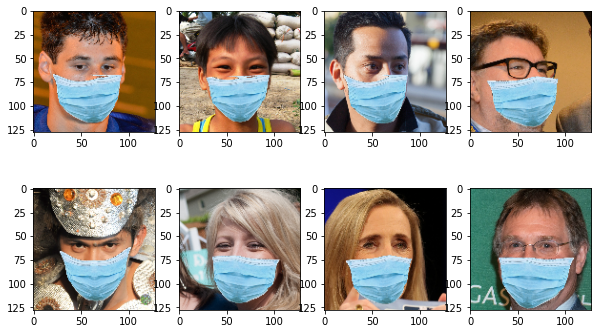

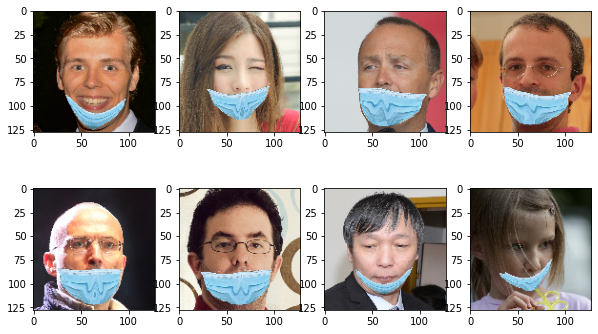

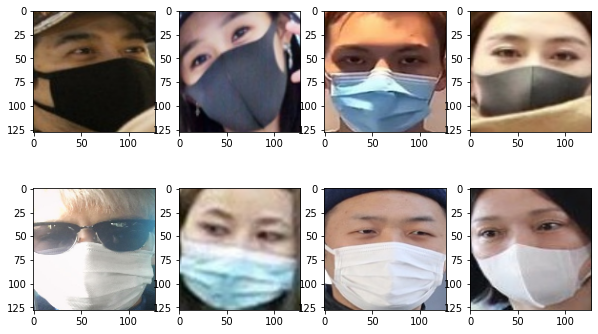

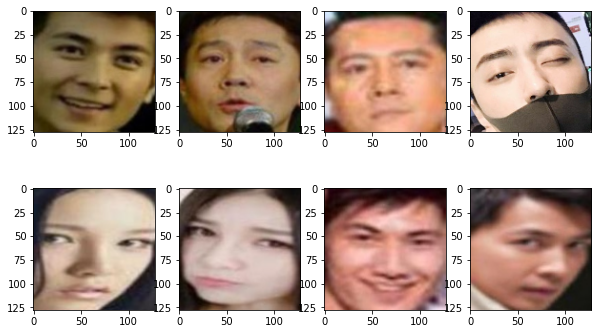

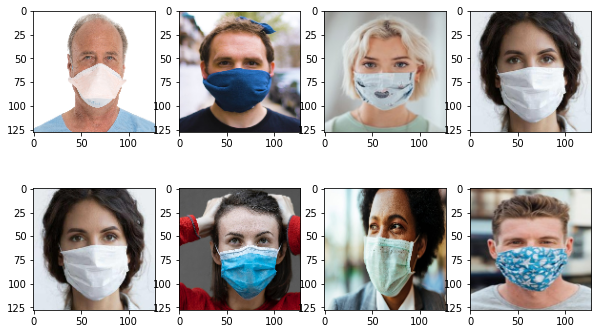

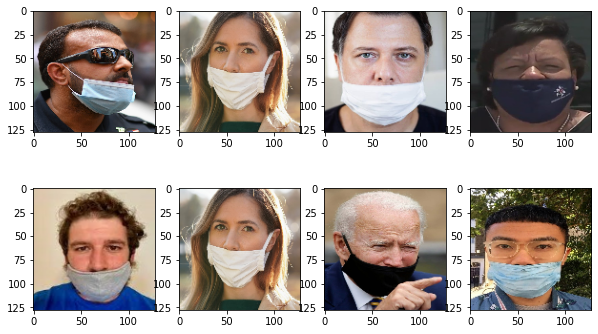

In [5]:
from random import randrange
# plot 25 random photos
for x in X:
    random_indx = []
    for i in range(8):
        random_indx.append(randrange(len(x)))

    fig, ax = plt.subplots(2,4,figsize=(10,6))
    count = 0
    for r in range(2):
        for c in range(4):
            ax[r][c].imshow(x[random_indx[count]],cmap='gray')
            count = count + 1
    plt.show()

### Create Train and Test samples 10 fold cross validation

Need to create a home-grown 10 fold to ensure each set has data from each of the databases

In [6]:
def k_fold_data_creation(X, n_folds):
    test_indices, train_indices = [],[]
    for j in range(n_folds):
        test_indices.append([])
        train_indices.append([])
        for i in range(len(X)):
            test_indices[j].append([])
            train_indices[j].append([])
    for t, x in enumerate(X):
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        for i in range(n_folds):
            first_indx = int(i*len(x)/(n_folds))
            last_indx = int((i+1)*len(x)/(n_folds))
            test_indices[i][t] = indices[first_indx:last_indx]
            train_indices[i][t] = np.concatenate((indices[0:first_indx],indices[last_indx:-1]))
    return test_indices, train_indices
    

Create the folds for each of the k test iterations

Note: Right now we have to keep it at 8 since there is a lack of samples from the "google" database

In [7]:
test_ind, train_ind = k_fold_data_creation(X, 10)

### Create CNN

In [8]:
# Our full CNN neural network
def create_model():
    cnn1 = tf.keras.Sequential()

    cnn1.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5),
        data_format='channels_last',
        name='conv_1', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_1'))

    cnn1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5),
        name='conv_2', activation='relu'))

    cnn1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

    cnn1.add(tf.keras.layers.Flatten())

    cnn1.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))

    cnn1.add(tf.keras.layers.Dense(units=2, name='fc_2', activation='softmax'))

        # Set a seed for repeatibility
    tf.random.set_seed(42)

    # Build the model
    cnn1.build(input_shape=(None, 128, 128, 3)) # None, 1024, 1024, 3 for rgb

    # Compile the model with the optimizer, loss function and metric
    cnn1.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])

    return cnn1

In [9]:
tp, fp, tn, fn = [], [], [], []
for i in range(3):
    tp.append([])
    fp.append([])
    tn.append([])
    fn.append([])
# k_fold x database size
for te_i, tr_i in zip(test_ind, train_ind):
    # create empty Train Index
    for i, train in enumerate(tr_i):
        if i == 0:
            X_train = X[i][train]
            Y_train = Y[i][train]
        else:
            X_train = np.concatenate((X_train, X[i][train]))
            Y_train = np.concatenate((Y_train, Y[i][train]))
    X_train = X_train/255
    print(f'{X_train.shape} {Y_train.shape}')
    cnn1 = create_model()
    history = cnn1.fit(X_train, Y_train,
        epochs=NUM_EPOCHS,
        shuffle=True)
    for i, test in enumerate(te_i):
        y_pred = cnn1.predict(X[i][test])
        y_pred = np.argmax(y_pred, axis=-1)
        y_check = np.argmax(Y[i][test], axis=-1) 
        m = int(i/2)
        if (i+2)%2 == 0: # even
            tp[m].append(sum(y_pred==y_check))
            fn[m].append(sum(y_pred!=y_check))
        else:
            tn[m].append(sum(y_pred==y_check))
            fp[m].append(sum(y_pred!=y_check))
        print(f'Size: {len(y_pred)} Accuracy {i}= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')
        

(6150, 128, 128, 3) (6150, 2)
Epoch 1/3
193/193 [==============================] - 35s 182ms/step - loss: 0.2442 - accuracy: 0.9233
Epoch 2/3
193/193 [==============================] - 35s 181ms/step - loss: 0.1333 - accuracy: 0.9559
Epoch 3/3
193/193 [==============================] - 35s 184ms/step - loss: 0.0592 - accuracy: 0.9811
Size: 250 Accuracy 0= 100.000
Size: 250 Accuracy 1= 99.200
Size: 187 Accuracy 2= 96.257
Size: 187 Accuracy 3= 91.444
Size: 2 Accuracy 4= 100.000
Size: 2 Accuracy 5= 0.000
(6148, 128, 128, 3) (6148, 2)
Epoch 1/3
193/193 [==============================] - 35s 182ms/step - loss: 0.2426 - accuracy: 0.9281
Epoch 2/3
193/193 [==============================] - 35s 184ms/step - loss: 0.0721 - accuracy: 0.9772
Epoch 3/3
193/193 [==============================] - 35s 183ms/step - loss: 0.0522 - accuracy: 0.9831
Size: 250 Accuracy 0= 97.600
Size: 250 Accuracy 1= 99.200
Size: 188 Accuracy 2= 94.681
Size: 188 Accuracy 3= 95.745
Size: 2 Accuracy 4= 100.000
Size: 2 Accur

### Report the metrics for each run and plot

In [ ]:
#ADD CONFUSION MATRIX CALCULATIONS

In [ ]:
#ADD PLOTS

In [11]:
for i in range(6):
    if i == 0:
        X_t = X[i]
        Y_t = Y[i]
    else:
        X_t = np.concatenate((X_t, X[i]))
        Y_t = np.concatenate((Y_t, Y[i]))
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.05, random_state=42)
cnn1 = create_model()
history = cnn1.fit(X_train, Y_train,
    epochs=NUM_EPOCHS,
    shuffle=True)
# Testing dataset
y_pred = cnn1.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_check = np.argmax(Y_test, axis=-1)
print(f'Accuracy= {sum(y_pred==y_check)/len(y_pred)*100:.3f}')

Epoch 1/3
209/209 [==============================] - 36s 170ms/step - loss: 40.0267 - accuracy: 0.8846
Epoch 2/3
209/209 [==============================] - 35s 169ms/step - loss: 0.1191 - accuracy: 0.9611
Epoch 3/3
209/209 [==============================] - 36s 172ms/step - loss: 0.0717 - accuracy: 0.9779
Accuracy= 95.455


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,9))
ax[0].plot(history.history['accuracy'])
ax[0].set_title('model accuracy')

ax[1].plot(history.history['loss'])
ax[1].set_title('model loss')

plt.show()